In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from utilities import *
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime

In [2]:
waterpump_data = pd.read_csv('C:\\Users\\I539001\\Desktop\\PA2\\AL\\FeedbackBoost\\Data\\Kaggle_Waterpump.csv')

In [3]:
waterpump_data.head()

,Unnamed: 0,rtf_id,ts_int,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,...,sensor_47,sensor_48,sensor_49,slice_id,cnt_per_rtf,cycle,RUL,RUL_pw,phase,IMM_FAILURE
0,1,1,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,...,38.194440,157.9861,67.70834,1,17155,1,17154,120,1,0
1,2,1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,...,38.194440,157.9861,67.70834,1,17155,2,17153,120,1,0
2,3,1,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,...,38.194443,155.9606,67.12963,1,17155,3,17152,120,1,0
3,4,1,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,...,38.194440,155.9606,66.84028,1,17155,4,17151,120,1,0
4,5,1,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,...,38.773150,158.2755,66.55093,1,17155,5,17150,120,1,0


In [4]:
waterpump_data.columns
# What are the following columns: 
# ts_int = 
# slice_id = 
# phase = 
# Imm_failure = 

Index(['Unnamed: 0', 'rtf_id', 'ts_int', 'timestamp', 'sensor_00', 'sensor_01',
       'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06',
       'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_16', 'sensor_17',
       'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22',
       'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27',
       'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32',
       'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37',
       'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42',
       'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47',
       'sensor_48', 'sensor_49', 'slice_id', 'cnt_per_rtf', 'cycle', 'RUL',
       'RUL_pw', 'phase', 'IMM_FAILURE'],
      dtype='object')

In [5]:
columns_to_drop = ['Unnamed: 0', 'timestamp', 'IMM_FAILURE', 'slice_id', 'cnt_per_rtf', 'IMM_FAILURE', 'ts_int', 'phase', 'RUL_pw']
waterpump_data= waterpump_data.drop(columns_to_drop, axis=1) 


In [6]:
rtf_ids = waterpump_data['rtf_id'].unique()
rtf_ids

array([1, 2, 4, 5, 6, 7], dtype=int64)

In [7]:
train_data = waterpump_data.loc[waterpump_data['rtf_id'].isin(list(rtf_ids[:4]))]

In [8]:
train_data

,rtf_id,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,cycle,RUL
0,1,2.465394,47.092010,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.925930,38.194440,157.986100,67.708340,1,17154
1,1,2.465394,47.092010,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.925930,38.194440,157.986100,67.708340,2,17153
2,1,2.444734,47.352430,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.215280,38.194443,155.960600,67.129630,3,17152
3,1,2.460474,47.092010,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.215280,38.194440,155.960600,66.840280,4,17151
4,1,2.445718,47.135410,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.793980,38.773150,158.275500,66.550930,5,17150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80204,5,0.364005,40.234380,45.225690,40.234375,206.576965,0.00000,11.35706,15.15480,15.29224,...,25.000000,32.29166,27.777780,27.77778,30.092592,29.224537,28.935180,29.513889,49640,4
80205,5,0.360069,40.190970,45.225693,40.234375,201.137131,0.00000,11.35706,15.15480,14.98843,...,25.000000,31.77083,28.067130,28.06713,30.092592,29.224537,28.935184,29.513889,49641,3
80206,5,0.360069,40.190971,45.225693,40.234380,201.293381,0.00000,11.27749,15.08247,15.18374,...,25.000000,31.51042,27.777780,27.77778,30.092590,29.224537,28.935184,29.513889,49642,2
80207,5,0.364005,40.190971,45.225693,40.190970,201.524887,0.00000,11.35706,15.12587,15.29224,...,24.739580,30.98958,28.067130,28.06713,29.513890,29.224537,28.935184,29.513889,49643,1


In [9]:
x_train_data = train_data.drop(['RUL'], axis=1)

In [10]:
train_data

,rtf_id,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,cycle,RUL
0,1,2.465394,47.092010,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.925930,38.194440,157.986100,67.708340,1,17154
1,1,2.465394,47.092010,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.925930,38.194440,157.986100,67.708340,2,17153
2,1,2.444734,47.352430,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.215280,38.194443,155.960600,67.129630,3,17152
3,1,2.460474,47.092010,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.215280,38.194440,155.960600,66.840280,4,17151
4,1,2.445718,47.135410,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.793980,38.773150,158.275500,66.550930,5,17150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80204,5,0.364005,40.234380,45.225690,40.234375,206.576965,0.00000,11.35706,15.15480,15.29224,...,25.000000,32.29166,27.777780,27.77778,30.092592,29.224537,28.935180,29.513889,49640,4
80205,5,0.360069,40.190970,45.225693,40.234375,201.137131,0.00000,11.35706,15.15480,14.98843,...,25.000000,31.77083,28.067130,28.06713,30.092592,29.224537,28.935184,29.513889,49641,3
80206,5,0.360069,40.190971,45.225693,40.234380,201.293381,0.00000,11.27749,15.08247,15.18374,...,25.000000,31.51042,27.777780,27.77778,30.092590,29.224537,28.935184,29.513889,49642,2
80207,5,0.364005,40.190971,45.225693,40.190970,201.524887,0.00000,11.35706,15.12587,15.29224,...,24.739580,30.98958,28.067130,28.06713,29.513890,29.224537,28.935184,29.513889,49643,1


In [11]:
test_data = waterpump_data.loc[waterpump_data['rtf_id'].isin(list(rtf_ids[4:]))]

In [12]:
test_data

,rtf_id,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,cycle,RUL
80209,6,0.305961,43.185760,38.15104,40.755210,121.507523,0.579826,11.35706,12.67361,12.66638,...,127.864600,84.37500,32.118057,32.986110,35.011570,33.854168,34.722220,32.407406,1,4699
80210,6,0.305961,43.576390,38.15104,40.668400,123.359375,0.088906,11.32089,12.62297,12.66638,...,128.906300,90.36458,32.118057,32.407410,35.011574,33.854168,34.722221,32.407406,2,4698
80211,6,0.305961,43.923610,38.15104,40.625000,122.664932,0.013632,11.32089,12.65191,12.67361,...,127.343700,95.05208,32.118057,32.407406,35.011574,33.854168,34.722221,32.407406,3,4697
80212,6,0.305961,44.270830,38.06424,40.581600,123.822342,0.557634,11.32089,12.62297,12.69531,...,124.739600,98.69791,32.118057,32.407410,35.011574,33.854168,34.722221,32.407410,4,4696
80213,6,0.305961,44.487850,38.15104,40.581600,122.433449,0.116625,11.35706,12.67361,12.65191,...,123.437500,103.38540,32.118057,32.986110,35.011570,33.854168,34.722221,32.407406,5,4695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110147,7,2.321759,45.789930,52.99479,44.010410,435.379028,73.424120,14.39525,16.20370,15.69734,...,36.718750,49.47916,52.083330,52.372680,60.763890,45.428240,247.974500,65.682870,25263,4
110148,7,2.313889,45.833330,53.03819,43.923610,71.464119,73.009800,14.36632,16.21094,15.69734,...,36.458332,49.47916,52.083330,51.793980,60.474540,45.138890,252.314800,69.155090,25264,3
110149,7,2.315856,45.833332,53.03819,43.923611,3.336227,72.475760,14.33015,16.16030,15.76968,...,36.197910,49.47916,52.083330,51.215280,60.474540,44.849540,253.182900,71.469910,25265,2
110150,7,2.322743,45.833330,52.99479,43.923610,3.336227,70.488890,14.46036,16.16030,15.73351,...,36.458330,49.73958,52.083330,52.083330,61.342590,44.849540,249.131900,72.337960,25266,1


In [13]:
def extract_RUL_per_rtf_id(df, rul_column_name = "RUL"): 
    RUL_per_rtf_ID = list()
    for rtf_id in df['rtf_id'].unique():
        RUL_per_rtf_ID.append(df.loc[df['rtf_id'] == rtf_id]['RUL'].iloc[-1])

    return   pd.DataFrame(RUL_per_rtf_ID, columns=['RUL_per_rtf_ID'])

In [14]:
test_RUL_per_rtf_id = extract_RUL_per_rtf_id(test_data, rul_column_name= "RUL")

In [15]:
test_RUL_per_rtf_id

,RUL_per_rtf_ID
0,0
1,0


In [16]:
y_test_RUL_per_cycle = test_data['RUL']
x_test_data = test_data.loc[:, test_data.columns!='RUL']

In [17]:
x_test_data

,rtf_id,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,cycle
80209,6,0.305961,43.185760,38.15104,40.755210,121.507523,0.579826,11.35706,12.67361,12.66638,...,31.250000,127.864600,84.37500,32.118057,32.986110,35.011570,33.854168,34.722220,32.407406,1
80210,6,0.305961,43.576390,38.15104,40.668400,123.359375,0.088906,11.32089,12.62297,12.66638,...,30.989580,128.906300,90.36458,32.118057,32.407410,35.011574,33.854168,34.722221,32.407406,2
80211,6,0.305961,43.923610,38.15104,40.625000,122.664932,0.013632,11.32089,12.65191,12.67361,...,30.989580,127.343700,95.05208,32.118057,32.407406,35.011574,33.854168,34.722221,32.407406,3
80212,6,0.305961,44.270830,38.06424,40.581600,123.822342,0.557634,11.32089,12.62297,12.69531,...,30.468750,124.739600,98.69791,32.118057,32.407410,35.011574,33.854168,34.722221,32.407410,4
80213,6,0.305961,44.487850,38.15104,40.581600,122.433449,0.116625,11.35706,12.67361,12.65191,...,30.468750,123.437500,103.38540,32.118057,32.986110,35.011570,33.854168,34.722221,32.407406,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110147,7,2.321759,45.789930,52.99479,44.010410,435.379028,73.424120,14.39525,16.20370,15.69734,...,36.458330,36.718750,49.47916,52.083330,52.372680,60.763890,45.428240,247.974500,65.682870,25263
110148,7,2.313889,45.833330,53.03819,43.923610,71.464119,73.009800,14.36632,16.21094,15.69734,...,36.197910,36.458332,49.47916,52.083330,51.793980,60.474540,45.138890,252.314800,69.155090,25264
110149,7,2.315856,45.833332,53.03819,43.923611,3.336227,72.475760,14.33015,16.16030,15.76968,...,36.197914,36.197910,49.47916,52.083330,51.215280,60.474540,44.849540,253.182900,71.469910,25265
110150,7,2.322743,45.833330,52.99479,43.923610,3.336227,70.488890,14.46036,16.16030,15.73351,...,36.197914,36.458330,49.73958,52.083330,52.083330,61.342590,44.849540,249.131900,72.337960,25266


In [18]:
from rul import RemainingUsefulLife

In [19]:
test  = RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, max_life=2*12*60, window_size=1, sequence_length=1, data_id= "waterpump")

training (80209, 46) (80209,)
testing (29943, 46) (29943,)


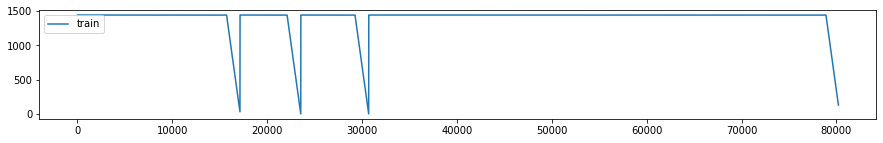

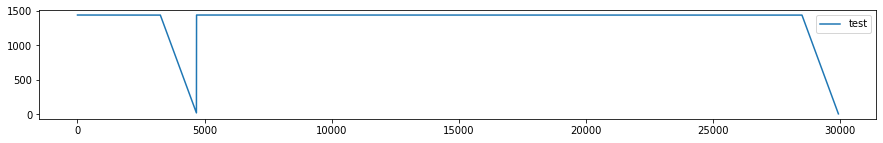

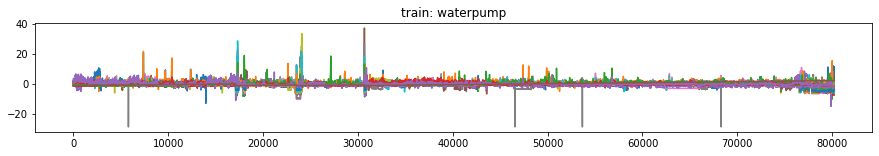

In [20]:
test.compute_piecewise_linear_rul()
test.feature_extension()
test.standard_normalization()
test.plot_rul()

training (80209, 46) (80209,)
testing (29943, 46) (29943,)
sequence_length + window_size is too large
sequence_length + window_size is too large
sequence_length + window_size is too large


IndexError: index 0 is out of bounds for axis 0 with size 0

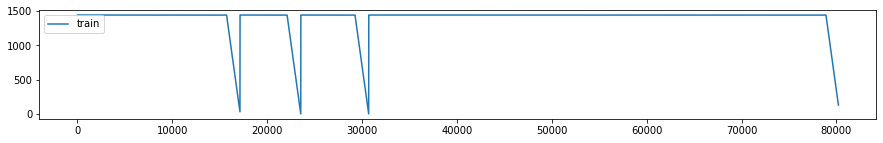

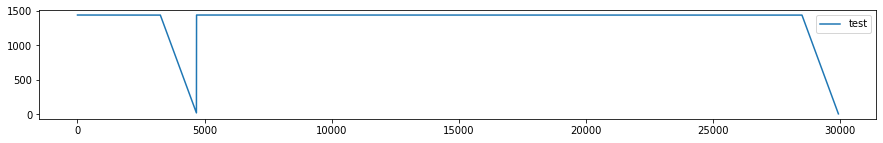

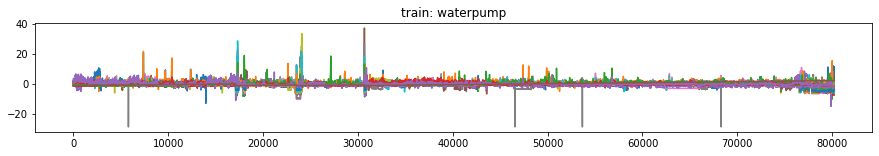

In [21]:
test.auto_rul()